In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray
import os
from tqdm import trange, tqdm
import cloud_correction as cc
from scipy.interpolate import interp1d
#from adjust183 import adjust183
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.stats import skew
plt.rcParams.update({'font.size': 16})

In [2]:
y = xarray.open_dataset(os.path.expanduser('~/Projects/git/aws/Validation/TB_AWS_m60_p60.nc'))
TB0 = y.TB
cases = TB0.cases.values.size

#IS = xarray.open_dataset(os.path.expanduser('~/Projects/git/aws/Validation/isurface.nc'))
#isurface = IS.i_surface         

In [3]:
A = xarray.open_dataset('/home/inderpreet/Projects/git/aws/Validation/TB_AWS_m60_p60_noise.nc')
TB = A.TB_noise
TB
channels= TB.channels.values
channel_names = [channels[i].replace('C', 'AWS-') for i in range(len(channels))]
channels
channel_names

['AWS-21',
 'AWS-31',
 'AWS-32',
 'AWS-33',
 'AWS-34',
 'AWS-35',
 'AWS-36',
 'AWS-4X',
 'AWS-41',
 'AWS-42',
 'AWS-43']

In [4]:
ias = 1
ics = 0

c183 = 'C34'
c325 = 'C42'
c229 = 'C32'

cs_reject    = 0.5
if c325 == 'C4X':
    dTb_max_fit  = 20
else:
    dTb_max_fit  = 40
    
dTb_max_meas = 15
#dTb_max_meas = 25

cs_frac_removed229 = 0.41
noisy_fit    = False
binstep      = 0.2

npoly = 3
allfits = True


4 9 2


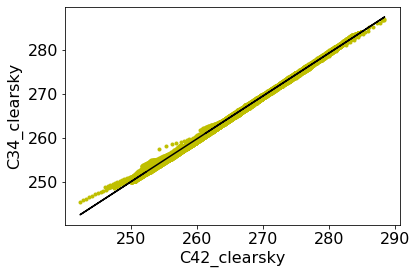

In [5]:
i183 = cc.get_index(c183, channels)
i325 = cc.get_index(c325, channels)
i229 = cc.get_index(c229, channels)

print(i183, i325, i229)

clearskyfit = cc.get_clearsky_fit(i183, i325, TB0, ics, channels)
#plt.savefig('Figures/%s_%s_scatter.png'%(c183, c325), bbox_inches='tight')

### select measurement data

In [7]:
tb183 = TB[i183, ias, :]
tb325 = TB[i325, ias, :]

im = np.where((abs(tb183 - tb325) <= dTb_max_meas))[0]

tb183 = tb183[im]
tb325 = tb325[im]
tb183_sim = TB[i183, ias, :]
ntot = cases
print(tb183.size/ntot)

0.9715845687868644


### find the index for the data to be used in the fits

In [8]:
ifit = np.where(np.abs(TB0[i325, ias, :] - TB0[i183, ias, :]) <= dTb_max_fit)[0]

In [9]:
def adjust183(tb183_cs_sim, tb183_as_sim, tb325_as_sim, tb183, tb325, tb183_sim, noise183, thin, npoly):

# Variables for fitting
    x = tb325_as_sim - tb183_as_sim
    y = tb183_cs_sim - tb183_as_sim

# Select subset to consider as cloudy for fitting and perform fit

    dtb_fit = 0.2
#    npoly   = 3

    cloudy0 = abs( y ) > 0.2

    
    p = np.polyfit(x[cloudy0], y[cloudy0], npoly)
    print (p)

# Init tb_cs_est

    tb_cs_est = tb183.copy()

    
# Create boolean for cases considered as cloudy and shall be adjusted
# We do this by finding cases where adjustment is > 2 std of noise
# (Tested and 1 std gives quite similar results, except for Ch32)

#    xtest      = np.arange(-10, 20, 0.2)
    xtest      = np.arange(-10, 3, 0.2)
    f          = interp1d( np.polyval(p, xtest), xtest)
    dtb        = f(noise183)
    print('dtb', dtb)
    x_measured = tb325 - tb183
    cloudy     = x_measured < dtb
    
    print ('% of simulations corrected: ', (tb183[cloudy].size*100)/x_measured.size )

#Apply adjustment
    tb_cs_est[cloudy] = tb183[cloudy] + np.polyval( p, x_measured[cloudy])
    tb_cs_rej = tb183[~cloudy]

          
    

    return tb_cs_est, tb_cs_rej


In [10]:
def plot_scatter(tb183_cs_sim, tb183_as_sim, tb325_as_sim, i183, i325, channels, npoly):
    x = tb325_as_sim - tb183_as_sim
    y = tb183_cs_sim - tb183_as_sim

# Select subset to consider as cloudy for fitting and perform fit

    dtb_fit = 0.2
#    npoly   = 3

    cloudy0 = abs( y ) > 0.2

    p = np.polyfit(x[cloudy0], y[cloudy0], npoly)
    
    xsort = np.sort(x[cloudy0])
    fig, ax = plt.subplots(1, 1, figsize = [8,8])
    ax.plot(x[cloudy0],y[cloudy0], 'g.')
    ax.plot(x[~cloudy0], y[~cloudy0], 'r.' )
    ax.plot(xsort, np.polyval(p, xsort), 'k')
    
    xpositive = np.arange(-10, 5, 0.1)
    ax.plot(xpositive, np.polyval(p, xpositive), 'k')
    
    y0 = 1.

    
    f = interp1d( np.polyval(p, xsort), xsort)
    dtb = f(y0)
    
    cloudy = x < dtb
    print(np.sum(cloudy), np.sum(~cloudy), x.size, np.sum(cloudy)/x.size)
    
    ax.axvline(x = dtb, ls = '--')
    ax.set_xlabel('TB %s allsky - TB %s allsky [K]'%(channels[i325], channels[i183]))
    ax.set_ylabel('TB %s clearsky - TB %s allsky [K]'%(channels[i183], channels[i183]))
    
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(2))
    ax.grid(which = 'both', alpha = 0.4)
    
    fig.savefig('Figures/fit_%s_%s.png'%(channels[i183], channels[i325]), bbox_inches='tight')

<xarray.DataArray 'TB' ()>
array(8462)
Coordinates:
    sky      <U6 'allsky' <xarray.DataArray 'TB' ()>
array(116109)
Coordinates:
    sky      <U6 'allsky' 124571 <xarray.DataArray 'TB' ()>
array(0.06792913)
Coordinates:
    sky      <U6 'allsky'


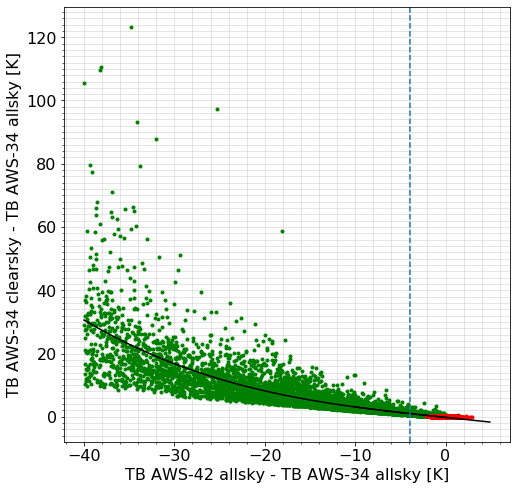

In [11]:
npoly = 3
plot_scatter(TB0[i183, ics, ifit], TB0[i183, ias, ifit], 
                          TB0[i325, ias, ifit], i183, i325, channel_names, npoly)

In [33]:
std = np.std(TB[i183, ics, :]-TB0[i183, ics, :])

if allfits:
    noise183 = 1.0*std  
    npoly = 1
    tb_cs_pre_1, tb_cs_rej_1 = adjust183(TB0[i183, ics, ifit], TB0[i183, ias, ifit], 
                          TB0[i325, ias, ifit], tb183, tb325, tb183_sim, noise183, thin, npoly)
    npoly = 2
    tb_cs_pre_2, tb_cs_rej_2 = adjust183(TB0[i183, ics, ifit], TB0[i183, ias, ifit], 
                          TB0[i325, ias, ifit], tb183, tb325, tb183_sim, noise183, thin, npoly)
    
    npoly = 3
    tb_cs_pre_3, tb_cs_rej_3 = adjust183(TB0[i183, ics, ifit], TB0[i183, ias, ifit], 
                          TB0[i325, ias, ifit], tb183, tb325, tb183_sim, noise183, thin, npoly)


[-0.58496441 -1.40035385]
dtb -3.47459670178984
% of simulations corrected:  5.60974609294885
[ 0.01523494 -0.11136577  0.21713606]
dtb -2.7161278046205544
% of simulations corrected:  7.9691537798925305
[-2.85535332e-04  4.01666303e-04 -2.96486783e-01 -1.83238982e-01]
dtb -2.7206975554462964
% of simulations corrected:  7.946183190450798


In [35]:
# pdf bins
bins = np.arange(-20, 5, binstep)

In [36]:
hist1  = np.histogram(TB[i183, ics, :] - TB0[i183, ics, :], bins, density = True)
hist2a = np.histogram(TB[i183, ias, :] - TB0[i183, ics, :], bins, density = True)
hist3_1  = np.histogram(tb_cs_pre_1 - TB0[i183, ics, :], bins, density = True)
hist3_2  = np.histogram(tb_cs_pre_2 - TB0[i183, ics, :], bins, density = True)
hist3_3  = np.histogram(tb_cs_pre_3 - TB0[i183, ics, :], bins, density = True)

### calculate bias

### plot deviations

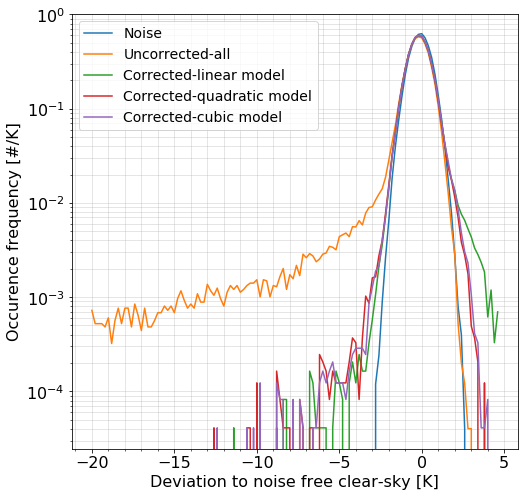

In [38]:
fig, ax = plt.subplots(1,1, figsize = [8,8])
  

ax.plot(bins[:-1], hist1[0])
ax.plot(bins[:-1], hist2a[0])
ax.plot(bins[:-1], hist3_1[0])
ax.plot(bins[:-1], hist3_2[0])
ax.plot(bins[:-1], hist3_3[0])
ax.set_yscale('log')
ax.set_ylabel('Occurence frequency [#/K]')
ax.set_xlabel('Deviation to noise free clear-sky [K]')
ax.legend(['Noise', 'Uncorrected-all', 'Corrected-linear model',
           'Corrected-quadratic model', 
           'Corrected-cubic model'],  prop={'size': 14})
    
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'both', alpha = 0.4)


fig.savefig('Figures/PDF_corrected_%s_%s_allfits.png'%(channel_names[i183], channel_names[i325]))

#### calculate statistics

In [42]:

b1  = np.mean(TB[i183, ics, :] - TB0[i183, ics, :]).values
b2a = np.mean(TB[i183, ias, :] - TB0[i183, ics, :]).values

b3_1  = np.mean(tb_cs_pre_1 - TB0[i183, ics, im]).values
b3_2  = np.mean(tb_cs_pre_2 - TB0[i183, ics, im]).values
b3_3  = np.mean(tb_cs_pre_3 - TB0[i183, ics, im]).values

In [39]:
std1  = np.std(TB[i183, ics, :] - TB0[i183, ics, :]).values
std2a = np.std(TB[i183, ias, :] - TB0[i183, ics, :]).values

std3_1  = np.std(tb_cs_pre_1 - TB0[i183, ics, :]).values
std3_2  = np.std(tb_cs_pre_2 - TB0[i183, ics, :]).values
std3_3  = np.std(tb_cs_pre_3 - TB0[i183, ics, :]).values

In [40]:
sk1  = skew(TB[i183, ics, :] - TB0[i183, ics, :])
sk2a = skew(TB[i183, ias, :] - TB0[i183, ics, :])

sk3_1  = skew(tb_cs_pre_1 - TB0[i183, ics, :])
sk3_2  = skew(tb_cs_pre_2 - TB0[i183, ics, :])
sk3_3  = skew(tb_cs_pre_3 - TB0[i183, ics, :])

In [44]:
rej3_1 = (1 - tb_cs_pre_1.size/ntot)*100
rej3_2 = (1 - tb_cs_pre_2.size/ntot)*100
rej3_3 = (1 - tb_cs_pre_3.size/ntot)*100


In [45]:
from tabulate import tabulate
rej1 = 0
rej2a = 0
b = [b1,  b2a, b3_1, b3_2, b3_3]
std = [std1,  std2a, std3_1, std3_2, std3_3]
skewness = [sk1,  sk2a, sk3_1, sk3_2, sk3_3]
rejected = [rej1, rej2a, rej3_1, rej3_2, rej3_3]
sets = ['Noise', 'uncorrected-all', 'corrected-linear model',
           'corrected-quadratic model', 
           'corrected-cubic model']

table  = [[sets[i], b[i], std[i], skewness[i], rejected[i]] for i in range(5)]

print(tabulate(table
         , ["Dataset","bias", "std", "measure skewness", "fraction rejected"],  tablefmt="latex", floatfmt=".2f"))


\begin{tabular}{lrrrr}
\hline
 Dataset                   &   bias &   std &   measure skewness &   fraction rejected \\
\hline
 Noise                     &   0.00 &  0.63 &               0.00 &                0.00 \\
 uncorrected-all           &  -0.75 &  4.62 &             -11.78 &                0.00 \\
 corrected-linear model    &  -0.03 &  0.75 &               0.48 &                2.84 \\
 corrected-quadratic model &  -0.06 &  0.71 &              -0.34 &                2.84 \\
 corrected-cubic model     &  -0.05 &  0.72 &              -0.23 &                2.84 \\
\hline
\end{tabular}
